In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
from pydybm.time_series.rnn_gaussian_dybm import RNNGaussianDyBM
from pydybm.base.sgd import RMSProp
from pydybm.base.generator import *
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pandas.read_csv('../Datasets/Gas_Furnace_Data.csv')

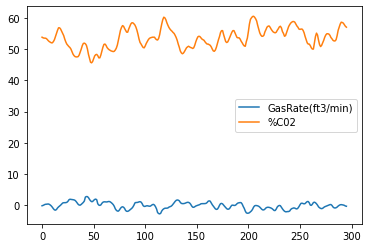

In [3]:
data.plot()
plt.show()

Helper Functions

In [4]:
def dybm_preprocess(data, split):
    values = data.values
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(values)
    scaled_tr, scaled_ts = scaled[:split], scaled[split:-1]
    dybm_tr = SequenceGenerator(scaled_tr)
    dybm_ts = SequenceGenerator(scaled_ts)
    return dybm_tr, dybm_ts

In [5]:
def RMSE(y_true, y_pred):
    y1 = y_true.flatten()
    y2 = y_pred.flatten()
    total = np.sum((y1 - y2) ** 2) / len(y1)
    return np.sqrt(total)

def MAE(y_true, y_pred):
    y1 = y_true.flatten()
    y2 = y_pred.flatten()
    total = np.sum(np.abs(y1 - y2)) / len(y1)
    return total

def MAE_by_var(y_true, y_pred):
    errors = []
    for i in range(y_true.shape[1]):
        errors.append(round(MAE(y_true[:, i], y_pred[:, i]), 5))
    return errors

In [6]:
def train_dybm(model, tr_set, ts_set=None, n_iter=20, verbose=False):
    all_errors = {'Training': [], 'Validation': []}
    for i in range(n_iter):
        model.init_state()
        tr_set.reset(i)
        result = model.learn(tr_set, get_result=True)
        errors = MAE_by_var(np.array(result["actual"]), np.array(result["prediction"]))
        all_errors['Training'].append(errors)
        
        # Get validation errors
        if not ts_set is None:
            dybm_ts.reset(0)
            preds, est = test_dybm(dybm_model, dybm_ts)
            y_errors = MAE_by_var(np.array(preds), np.array(est))
            all_errors['Validation'].append(y_errors)
        
        # Output current iteration errors
        if verbose:
            dybm_iter_output = 'Iteration ' + str(i + 1) + ' MAE: '
            for j in range(len(errors)):
                dybm_iter_output += 'X' + str(j + 1) + ': ' + str(errors[j]) + ' - '
            if not ts_set is None:
                for j in range(len(y_errors)):
                    dybm_iter_output += 'X' + str(j + 1) + ' (Val): ' + str(y_errors[j]) + ' - '
            print(dybm_iter_output[:-3])
    
    # Save last obtained and expected observations (including test results, if provided)
    last_res = {'Actual': np.array(result['actual']), 'Prediction': np.array(result['prediction'])}
    if not ts_set is None:
        last_res_ts = {'Actual': np.array(preds), 'Prediction': np.array(est)}
    
    all_errors['Training'] = np.array(all_errors['Training'])
    all_errors['Validation'] = np.array(all_errors['Validation'])
    all_errors['Res_Training'] = last_res
    all_errors['Res_Validation'] = last_res_ts
        
    return model, all_errors

In [7]:
# Obtain weights of each feature
def process_dybm_results(weights):
    labels = ['X' + str(i) for i in range(1, weights.shape[1] + 1)]
    for i in range(1, weights.shape[0]):
        labels += ['X' + str(j) + '-' + str(i) for j in range(1, weights.shape[1] + 1)]
    
    params = {'labels': labels}
    for i in range(weights.shape[2]):
        vals = weights[:, :, i].flatten()
        params['X' + str(i + 1)] = vals
    
    return params

In [8]:
# Similar to dybm.learn, but without parameter updates
def test_dybm(model, test_set):
    preds = []
    est = []
    for in_p in test_set:
        out_p = in_p
        pred = model.predict_next()
        preds.append(pred)
        est.append(out_p)
        model._update_state(in_p)
    return preds, est

Create and train an RNN Gaussian DyBM

In [9]:
in_dim = data.shape[1]
out_dim = data.shape[1]
rnn_dim = 10
max_iter = 20
SGD = RMSProp

delay = 5
decay = 0.5
sparsity = 0.5
spectral_radius = 0.95
leak = 0.5
learning_rate = 0.0005
random_seed = 2

max_iter = 40

In [10]:
data_dif = data.diff().dropna()
dybm_tr, dybm_ts = dybm_preprocess(data_dif, 250)

In [11]:
dybm_model = RNNGaussianDyBM(in_dim,out_dim,rnn_dim,spectral_radius,sparsity,delay=delay,
                        decay_rates =[decay],leak=leak, random_seed = random_seed, SGD=SGD())  
dybm_model.set_learning_rate(learning_rate)

dybm_model, dybm_errors = train_dybm(dybm_model, dybm_tr, dybm_ts, n_iter=max_iter, verbose=True)

Iteration 1 MAE: X1: 0.18371 - X2: 0.26923 - X1 (Val): 0.15495 - X2 (Val): 0.29265
Iteration 2 MAE: X1: 0.1592 - X2: 0.1815 - X1 (Val): 0.14673 - X2 (Val): 0.24579
Iteration 3 MAE: X1: 0.14736 - X2: 0.12542 - X1 (Val): 0.14316 - X2 (Val): 0.21531
Iteration 4 MAE: X1: 0.13991 - X2: 0.09719 - X1 (Val): 0.14027 - X2 (Val): 0.19432
Iteration 5 MAE: X1: 0.13451 - X2: 0.08407 - X1 (Val): 0.13758 - X2 (Val): 0.18027
Iteration 6 MAE: X1: 0.13062 - X2: 0.07826 - X1 (Val): 0.13422 - X2 (Val): 0.17237
Iteration 7 MAE: X1: 0.12756 - X2: 0.07644 - X1 (Val): 0.13054 - X2 (Val): 0.16749
Iteration 8 MAE: X1: 0.1253 - X2: 0.07561 - X1 (Val): 0.12735 - X2 (Val): 0.16476
Iteration 9 MAE: X1: 0.12341 - X2: 0.07516 - X1 (Val): 0.12448 - X2 (Val): 0.16325
Iteration 10 MAE: X1: 0.12187 - X2: 0.07491 - X1 (Val): 0.12176 - X2 (Val): 0.16234
Iteration 11 MAE: X1: 0.12058 - X2: 0.07481 - X1 (Val): 0.11912 - X2 (Val): 0.16175
Iteration 12 MAE: X1: 0.11943 - X2: 0.07475 - X1 (Val): 0.11665 - X2 (Val): 0.16138
Iter

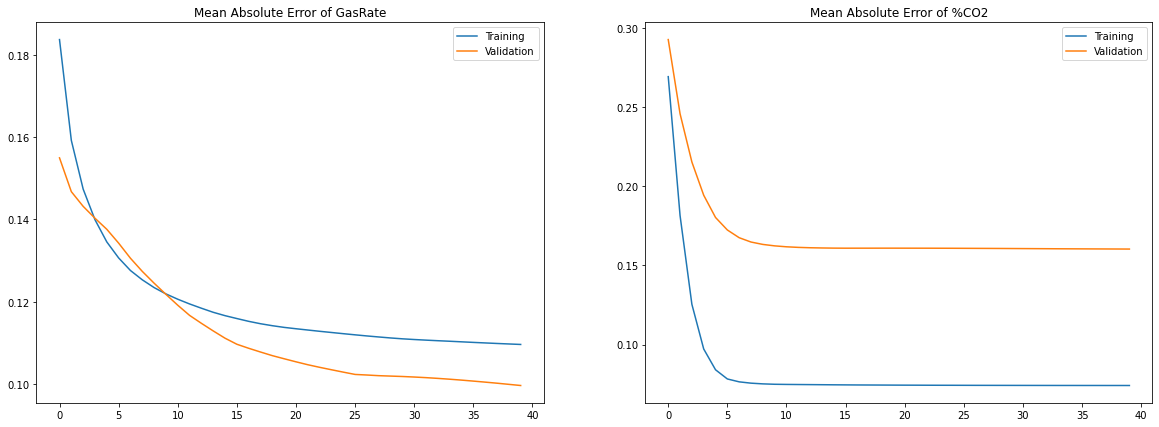

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# GasRate variable error plot
axs[0].plot(dybm_errors['Training'][:, 0], label='Training')
axs[0].plot(dybm_errors['Validation'][:, 0], label='Validation')
axs[0].set_title('Mean Absolute Error of GasRate')
axs[0].legend()

# %CO2 variable error plot
axs[1].plot(dybm_errors['Training'][:, 1], label='Training')
axs[1].plot(dybm_errors['Validation'][:, 1], label='Validation')
axs[1].set_title('Mean Absolute Error of %CO2')
axs[1].legend()

plt.show()

Plot time series results and test for autocorrelation in residuals (Ljung-Box test)

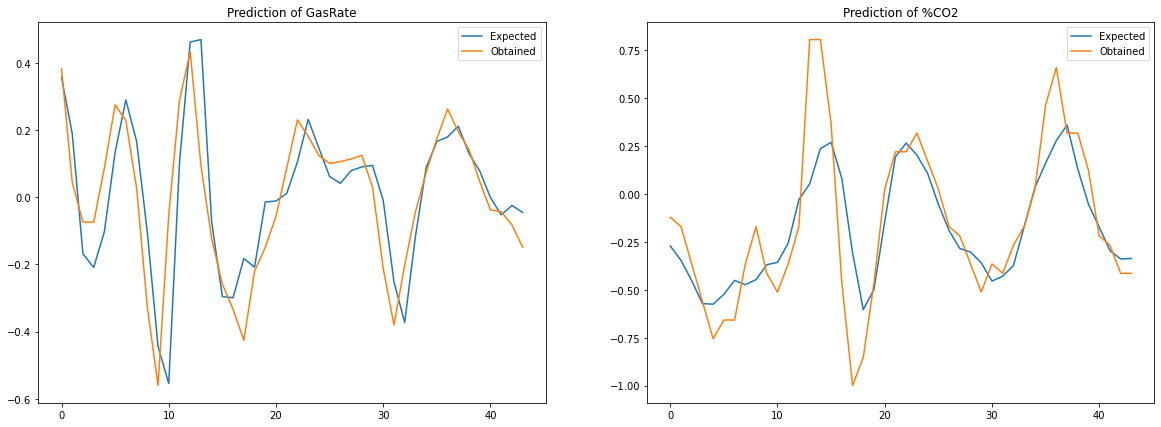

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

axs[0].plot(dybm_errors['Res_Validation']['Actual'][:, 0], label='Expected')
axs[0].plot(dybm_errors['Res_Validation']['Prediction'][:, 0], label='Obtained')
axs[0].set_title('Prediction of GasRate')
axs[0].legend()

axs[1].plot(dybm_errors['Res_Validation']['Actual'][:, 1], label='Expected')
axs[1].plot(dybm_errors['Res_Validation']['Prediction'][:, 1], label='Obtained')
axs[1].set_title('Prediction of %CO2')
axs[1].legend()

plt.show()

In [14]:
def count_vals_below_pvalue(vals):
    counter = 0
    for val in vals:
        if val < 0.05:
            counter += 1
    return counter

In [15]:
resids_1 = dybm_errors['Res_Validation']['Actual'][:, 0] - dybm_errors['Res_Validation']['Prediction'][:, 0]
resids_2 = dybm_errors['Res_Validation']['Actual'][:, 1] - dybm_errors['Res_Validation']['Prediction'][:, 1]

num_lags = 10

res_1 = acorr_ljungbox(resids_1, lags=num_lags, return_df=True)
res_2 = acorr_ljungbox(resids_2, lags=num_lags, return_df=True)

total_1_pvals = count_vals_below_pvalue(res_1['lb_pvalue'].values)
print('Ljung-Box test statistic for GasFurnace:', total_1_pvals,
      'lags below p-value', '(' + str(round(total_1_pvals / num_lags, 2) * 100) + '%)') 
      
total_2_pvals = count_vals_below_pvalue(res_2['lb_pvalue'].values)
print('Ljung-Box test statistic for %CO2:', total_2_pvals,
     'lags below p-value', '(' + str(round(total_2_pvals / num_lags, 2) * 100) + '%)')

Ljung-Box test statistic for GasFurnace: 9 lags below p-value (90.0%)
Ljung-Box test statistic for %CO2: 10 lags below p-value (100.0%)


Study the contribution of each input feature (Model weights) <br>
Higher absolute values contribute more to their respective output

In [16]:
dybm_weights = process_dybm_results(dybm_model.variables['W'])

<ipython-input-17-05e9a2cf0293>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(dybm_weights['labels'], rotation=-45)


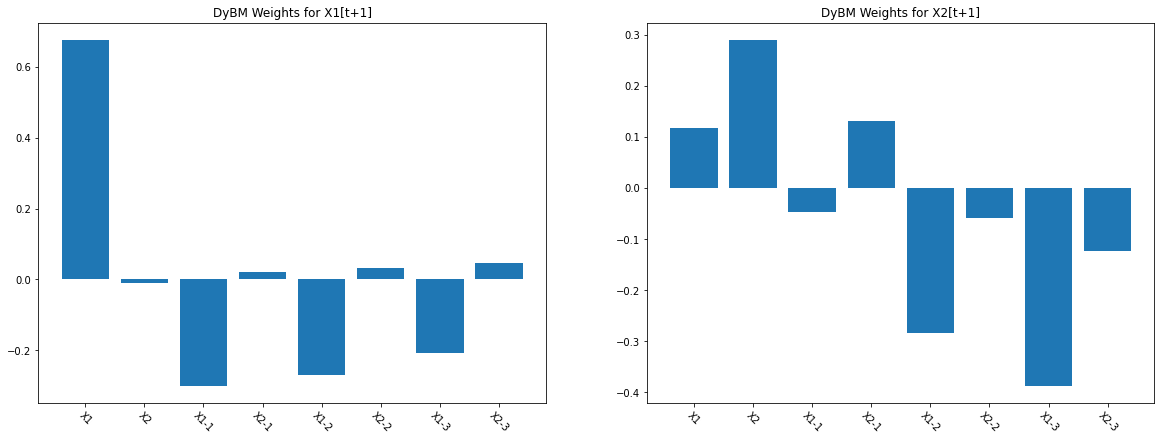

In [17]:
# Plot weights (higher absolute values contribute more to their respective output)
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

for i in range(len(data.columns)):
  axs[i].bar(dybm_weights['labels'], dybm_weights['X' + str(i + 1)])
  axs[i].set_xticklabels(dybm_weights['labels'], rotation=-45)
  axs[i].set_title('DyBM Weights for X' + str(i + 1) + '[t+1]')

plt.show()